# **install needed libraries**

In [3]:
!pip install numpy
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 5.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630125 sha256=9dce7c6053a88d622247b438dc9b26c10c53e0d48a762ffa392772704cb61705
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


**import useful libraries**

In [99]:
import surprise
from surprise import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.sparse import csr_matrix
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic,SVD
from surprise.prediction_algorithms import matrix_factorization as mf
from surprise.prediction_algorithms.co_clustering import CoClustering as cc
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
import sklearn
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Data Analysis

In [84]:
movies = pd.read_csv('/content/drive/MyDrive/ml-20m/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ml-20m/ratings.csv')
tags= pd.read_csv('/content/drive/MyDrive/ml-20m/tags.csv')
data = pd.merge(left=movies, right=ratings, on='movieId')
reader = Reader(rating_scale=(0.5, 5.0))

In [9]:
data.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,944919407
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,858275452
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,833981871
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,943497887
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,1230858821


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [10]:
user,item,rating= data["userId"],data["movieId"],data["rating"]
max_user,max_item = user.nunique(),item.nunique()
max_rating,min_rating,avg_rating=rating.max(),rating.min(),rating.mean()
print("Number of user:->",max_user)
print("Number of item:->",max_item)
print("max rating :->",max_rating)
print("min rating:->",min_rating)
print("avg rating :->",avg_rating)
mean_ratings = data.groupby('userId')['rating'].mean()
meanofuser=mean_ratings.mean()
print("avg rating by user :->",meanofuser)

Number of user:-> 138493
Number of item:-> 26744
max rating :-> 5.0
min rating:-> 0.5
avg rating :-> 3.5255285642993797
avg rating by user :-> 3.627208621886526


number of geners and movies

In [12]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
ge = Counter(g for genres in movies['genres'] for g in genres)
ge

Counter({'(no genres listed)': 246,
         'Action': 3520,
         'Adventure': 2329,
         'Animation': 1027,
         'Children': 1139,
         'Comedy': 8374,
         'Crime': 2939,
         'Documentary': 2471,
         'Drama': 13344,
         'Fantasy': 1412,
         'Film-Noir': 330,
         'Horror': 2611,
         'IMAX': 196,
         'Musical': 1036,
         'Mystery': 1514,
         'Romance': 4127,
         'Sci-Fi': 1743,
         'Thriller': 4178,
         'War': 1194,
         'Western': 676})

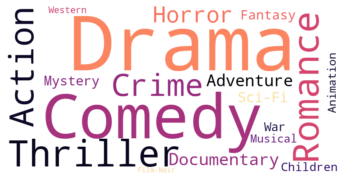

In [11]:
movie_genres = []

for genre in movies['genres']:
    for movie in genre.split('|'):
        movie_genres.append(movie)

genre_counts = pd.Series(movie_genres).value_counts()[:18]

from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='magma')
genres_cloud.generate_from_frequencies(genre_counts)

plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

here in the histogram of rating we can clearly see that 4.5 is highest rated by users and average rating is aroung 3.5 and also we can observ that the users are more prone to give 5 star rather than 0.5

(array([ 239125.,  680732.,  279252., 1430997.,  883398., 4291193.,
        2200156., 5561926., 4433484.]),
 array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 9 Patch objects>)

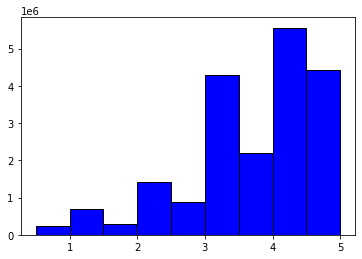

In [13]:
plt.hist(data['rating'], bins=list(np.arange(0.5,5.5,0.5)), color='blue', ec='black')

# (i) Naive Bayes

In [35]:
movies['genres'] = movies.genres.str.split('|')
m = movies.copy()
for index, row in movies.iterrows():
    for genre in row['genres']:
        m.at[index, genre] = 1
m = m.fillna(0)
m.head()

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),[Comedy],0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
m=m.drop(['genres'],axis=1)

In [38]:
final=pd.merge(left=m, right=data, on='movieId')

In [39]:
sentiment = {0.5:'dislike',1:'dislike',1.5:'dislike',2:'dislike',2.5:'dislike',3:'dislike',3.5:'like',4:'like',4.5:'like',5:'like'}
final["senti"]=final['rating'].map(sentiment)

In [48]:
final=final.drop(['title_y'],axis=1)

In [66]:
X=final.iloc[:,:-2].values
Y = final.iloc[:,-1:].values

In [67]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:,1]= le.fit_transform(X[:,1])
Y= le.fit_transform(Y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [56]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [57]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [58]:
y_pred  =  classifier.predict(X_test)

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.4223742416388575

# (ii)Logistic Regression

In [ ]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn.linear_model import LogisticRegression
 
# Building the logistic model
Logmod = LogisticRegression()
Logmod.fit(X_train, y_train)
 
# Creating x_var data for new user

y_pred = Logmod.predict(X_test)

In [70]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.49527769988159165

# (iii) KNN

In [76]:
data=data.drop(['title','senti','timestamp'],axis=1)
data

,movieId,userId,rating
0,1,3,4.0
1,1,6,5.0
2,1,8,4.0
3,1,10,4.0
4,1,11,4.5
...,...,...,...
49995,2,1887,2.5
49996,2,1892,2.5
49997,2,1904,3.0
49998,2,1906,3.0


In [80]:
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


In [77]:
data=Dataset.load_from_df(data[['movieId', 'userId','rating']], reader)

In [78]:
sim_options = {'name': 'cosine',
               'user_based': True  
               }
algo = KNNBasic(sim_options=sim_options)
trainset = data.build_full_trainset()
algo.fit(trainset)
testset = trainset.build_testset()
predictions = algo.test(testset)
accuracy.rmse(predictions, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.0552


0.05523361974374641

#(iv) SVD

In [86]:
data=data.iloc[:50000,:]

In [89]:
data=data.drop(['title','genres','timestamp'],axis=1)

In [91]:
data=Dataset.load_from_df(data[['movieId', 'userId','rating']], reader)

In [98]:

algo =mf.SVD()
trainset = data.build_full_trainset()
algo.fit(trainset)
testset = trainset.build_testset()
predictions = algo.test(testset)
accuracy.rmse(predictions, verbose=True)

RMSE: 0.7703


0.7703377683504249

#(v) co-clustering

In [100]:
algo =cc()
trainset = data.build_full_trainset()
algo.fit(trainset)
testset = trainset.build_testset()
predictions = algo.test(testset)
accuracy.rmse(predictions, verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE: 0.2193


0.21929412599333012